In [1]:
import time

In [2]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Datasets

In [3]:
names = ['wine', 'default_credit', 'compas', 'lsat']
bnn_widths = [200, 200, 200, 200]
bnn_depths = [2, 2, 2, 2]

vae_widths = [300, 300, 300, 300] # [200, 200, 200, 200]
vae_depths = [3, 3, 3, 3] # We go deeper because we are using residual models
vae_latent_dims = [6, 8, 4, 4]

# For automatic explainer generation

regression_bools = [True, False, False, True]
gauss_cat_vae_bools = [False, True, True, True]
flat_vae_bools = [False, False, False, False]

var_names = {}
var_names_flat = {}

var_names['wine'] = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
var_names_flat['wine'] = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

var_names['default_credit'] = ['Given credit', 'Gender', 'Education', 'Marital status', 'Age', 'Payment delay 1', 'Payment delay 2',
            'Payment delay 3', 'Payment delay 4', 'Payment delay 5', 'Payment delay 6', 'Bill statement 1', 'Bill statement 2',
            'Bill statement 3', 'Bill statement 4', 'Bill statement 5', 'Bill statement 6', 'Previous payment 1', 'Previous payment 2',
            'Previous payment 3', 'Previous payment 4', 'Previous payment 5', 'Previous payment 6']
var_names_flat['default_credit'] = ['Given credit', 'Gender M', 'Gender F', 'Education grad', 'Education under', 'Education HS', 'Education Other',
                 'Marital status M', 'Marital status S', 'Marital status Other', 'Age', 'Payment delay 1', 'Payment delay 2',
            'Payment delay 3', 'Payment delay 4', 'Payment delay 5', 'Payment delay 6', 'Bill statement 1', 'Bill statement 2',
            'Bill statement 3', 'Bill statement 4', 'Bill statement 5', 'Bill statement 6', 'Previous payment 1', 'Previous payment 2',
            'Previous payment 3', 'Previous payment 4', 'Previous payment 5', 'Previous payment 6']

var_names['compas'] = ["age_cat", "race", "sex", "c_charge_degree", 'is_recid', 'priors_count', 'time_served']
var_names_flat['compas'] = ['25 - 45', 'Greater than 45', 'Less than 25', 'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other', 'Female', 'Male', 'Felony', 'misdemeanour', 'not_recid', 'is_recid', 'priors_count', 'time_served']

var_names['lsat'] = ['LSAT', 'UGPA', 'race', 'sex']
var_names_flat['lsat'] = ['LSAT', 'UGPA', 'amerind', 'mexican', 'other', 'black', 'asian', 'puerto', 'hisp', 'white', 'female', 'male']


# Choose dataset

In [4]:
dname = 'compas'

In [5]:
from random import seed
import numpy as np
import os
import urllib.request
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def load_UCI(dset_name, splits=10, seed=0, separate_targets=True, save_dir='data/'):
    mkdir(save_dir)

    if dset_name == 'boston':
        if not os.path.isfile(save_dir+'housing.data'):
            urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data",
                               filename=save_dir+'housing.data')
        data = pd.read_csv(save_dir + 'housing.data', header=0, delimiter="\s+").values
        y_idx = [-1]

    elif dset_name == 'concrete':
        if not os.path.isfile(save_dir+'Concrete_Data.xls'):
            urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls",
                               filename=save_dir+'Concrete_Data.xls')
        data = pd.read_excel(save_dir+ 'Concrete_Data.xls', header=0, delimiter="\s+").values
        y_idx = [-1]

    elif dset_name == 'energy':
        if not os.path.isfile(save_dir+'ENB2012_data.xlsx'):
            urllib.urlretrieve("http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx",
                               filename=save_dir+'ENB2012_data.xlsx')
        data = pd.read_excel(save_dir+'ENB2012_data.xlsx', header=0, delimiter="\s+").values
        y_idx = [-2, -1]

    elif dset_name == 'power':
        if not os.path.isfile(save_dir+'CCPP.zip'):
            urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip",
                               filename=save_dir+'CCPP.zip')
        zipped = zipfile.ZipFile(save_dir+"CCPP.zip")
        data = pd.read_excel(zipped.open('CCPP/Folds5x2_pp.xlsx'), header=0, delimiter="\t").values
        y_idx = [-1]

    elif dset_name == 'wine':
        if not os.path.isfile(save_dir+'winequality-red.csv'):
            urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                               filename=save_dir+'winequality-red.csv')
        data = pd.read_csv(save_dir+'winequality-red.csv', header=1, delimiter=';').values
        y_idx = [-1]

    elif dset_name == 'yatch':
        if not os.path.isfile(save_dir+'yacht_hydrodynamics.data'):
            urllib.urlretrieve("http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data",
                               filename=save_dir+'yacht_hydrodynamics.data')
        data = pd.read_csv(save_dir+'yacht_hydrodynamics.data', header=1, delimiter='\s+').values
        y_idx = [-1]

    elif dset_name == 'kin8nm':
        if not os.path.isfile(save_dir+'dataset_2175_kin8nm.csv'):
            urllib.urlretrieve("https://www.openml.org/data/get_csv/3626/dataset_2175_kin8nm.csv",
                               filename=save_dir+'dataset_2175_kin8nm.csv')
        data = pd.read_csv(save_dir+'dataset_2175_kin8nm.csv', header=1, delimiter=',').values
        y_idx = [-1]

    elif dset_name == 'kin8nm':
        if not os.path.isfile(save_dir+'dataset_2175_kin8nm.csv'):
            urllib.urlretrieve("https://www.openml.org/data/get_csv/3626/dataset_2175_kin8nm.csv",
                               filename=save_dir+'dataset_2175_kin8nm.csv')
        data = pd.read_csv(save_dir+'dataset_2175_kin8nm.csv', header=1, delimiter=',').values
        y_idx = [-1]

    elif dset_name == 'naval':
        if not os.path.isfile(save_dir + 'UCI%20CBM%20Dataset.zip'):
            urllib.urlretrieve("http://archive.ics.uci.edu/ml/machine-learning-databases/00316/UCI%20CBM%20Dataset.zip",
                               filename=save_dir + 'UCI%20CBM%20Dataset.zip')
        zipped = zipfile.ZipFile(save_dir + "UCI%20CBM%20Dataset.zip")
        data = pd.read_csv(zipped.open('UCI CBM Dataset/data.txt'), header='infer', delimiter="\s+").values
        y_idx = [-2, -1]

    elif dset_name == 'protein':
        if not os.path.isfile(save_dir+'CASP.csv'):
            urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv",
                               filename=save_dir+'CASP.csv')
        data = pd.read_csv(save_dir+'CASP.csv', header=1, delimiter=',').values
        y_idx = [0]

    elif dset_name == 'default_credit':
        if not os.path.isfile(save_dir + 'default of credit card clients.xls'):
            urllib.request.urlretrieve(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                filename=save_dir + 'default of credit card clients.xls')
        data = pd.read_excel(save_dir + 'default of credit card clients.xls', header=[0, 1], index_col=0, # delimiter="\s+"
                             ).values
        y_idx = [-1]  # OK


    else:
        raise Exception('Dataset name doesnt match any known datasets.')

    np.random.seed(seed)
    data = data[np.random.permutation(np.arange(len(data)))]

    kf = KFold(n_splits=splits)
    for j, (train_index, test_index) in enumerate(kf.split(data)):

        if separate_targets:
            x_idx = list(range(data.shape[1]))
            for e in y_idx:
                x_idx.remove(x_idx[e])

            x_idx = np.array(x_idx)
            y_idx = np.array(y_idx)
            x_train, y_train = data[train_index, :], data[train_index, :]
            x_train, y_train = x_train[:, x_idx], y_train[:, y_idx]
            x_test, y_test = data[test_index, :], data[test_index, :]
            x_test, y_test = x_test[:, x_idx], y_test[:, y_idx]

            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)
            y_means, y_stds = y_train.mean(axis=0), y_train.std(axis=0)

            y_stds[y_stds < 1e-10] = 1
            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            y_train = ((y_train - y_means) / y_stds).astype(np.float32)

            x_test = ((x_test - x_means) / x_stds).astype(np.float32)
            y_test = ((y_test - y_means) / y_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds

        else:
            x_train, x_test = data[train_index, :], data[test_index, :]
            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)

            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            x_test = ((x_test - x_means) / x_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds


def get_my_COMPAS(rseed=0, separate_test=True, test_ratio=0.2, save_dir='../data/'):
    """
        The adult dataset can be obtained from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
        The code will look for the data file in the present directory, if it is not found, it will download them from GitHub.
    """

    SEED = rseed
    seed(SEED)
    np.random.seed(SEED)

    their_FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]
    FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "c_charge_degree", "is_recid", "priors_count",
                               "time_served"]  # features to be used for classification
    CONT_VARIABLES = ["priors_count",
                      "time_served"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "two_year_recid"  # the decision variable


    COMPAS_INPUT_FILE = save_dir + "compas-scores-two-years.csv"
    check_data_file(COMPAS_INPUT_FILE)

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df = df.dropna(subset=["days_b_screening_arrest"])  # dropping missing vals

    # convert to np array
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])

    dates_in = data['c_jail_in']
    dates_out = data['c_jail_out']
    # this measures time in Jail
    time_served = []
    for i in range(len(dates_in)):
        di = datetime.datetime.strptime(dates_in[i], '%Y-%m-%d %H:%M:%S')
        do = datetime.datetime.strptime(dates_out[i], '%Y-%m-%d %H:%M:%S')
        time_served.append((do - di).days)
    time_served = np.array(time_served)
    time_served[time_served < 0] = 0
    data["time_served"] = time_served

    """ Filtering the data """

    # These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
    # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    idx = np.logical_and(data["days_b_screening_arrest"] <= 30, data["days_b_screening_arrest"] >= -30)

    # We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    idx = np.logical_and(idx, data["is_recid"] != -1)

    # In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    idx = np.logical_and(idx, data["c_charge_degree"] != "O")  # F: felony, M: misconduct

    # We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
    idx = np.logical_and(idx, data["score_text"] != "NA")

    # select the examples that satisfy this criteria
    for k in data.keys():
        data[k] = data[k][idx]

    y = data[CLASS_FEATURE]
    """ Feature normalization and one hot encoding """

    print
    "\nNumber of people recidivating within two years"
    print
    pd.Series(y).value_counts()
    print
    "\n"

    X = []  # empty array with num rows same as num examples, will hstack the features to it
    X_dims = []

    feature_names = []
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            # vals = preprocessing.scale(vals, axis=0, with_mean=True, with_std=True)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            X_dims.append(1)

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
            enc.fit(vals.reshape(-1, 1))
            vals = enc.transform(vals.reshape(-1, 1)).todense()
            X_dims += [vals.shape[1]]*vals.shape[1]

        # add to learnable features
        X.append(vals)

        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in enc.categories_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    X = np.array(np.concatenate(list(X), axis=1))
    X_dims = np.array(X_dims)

    if separate_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rseed, shuffle=True)

        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
        x_means[X_dims>1] = 0
        x_stds[X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X_train - x_means) / x_stds).astype(np.float32)
        x_test = ((X_test - x_means) / x_stds).astype(np.float32)

        return x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims
    else:
        x_means, x_stds = X.mean(axis=0), X.std(axis=0)
        print(X_dims.shape, x_means.shape)
        x_means[:,X_dims>1] = 0
        x_stds[:,X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X - x_means) / x_stds).astype(np.float32)

        return x_train, x_means, x_stds, y, feature_names, X_dims

# Some util functions

In [6]:
def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        
        response = urllib.request.urlopen(addr)

        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."

def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)
            
def unnormalise_cat_vars(x, x_means, x_stds, input_dim_vec):
    input_dim_vec = np.array(input_dim_vec)
    unnorm_x = np.multiply(x, x_stds) + x_means

    fixed_unnorm = unnorm_x.round()
    # -=
    fixed_unnorm = fixed_unnorm - fixed_unnorm.min(axis=0).reshape([1, fixed_unnorm.shape[1]])  # this sets all mins to 0
    for idx, dims in enumerate(input_dim_vec):
        if dims > 1:
            vec = fixed_unnorm[:, idx]
            vec[vec > dims - 1] = dims - 1
            fixed_unnorm[:, idx] = vec

    x[:, input_dim_vec > 1] = fixed_unnorm[:, input_dim_vec > 1]
    return x

def X_dims_to_input_dim_vec(X_dims):
    """This is for our cat_Gauss VAE model"""
    input_dim_vec = []
    i = 0
    while i < len(X_dims):
        input_dim_vec.append(X_dims[i])
        i += X_dims[i]
    return np.array(input_dim_vec)

def gauss_cat_to_flat(x, input_dim_vec):
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output.append(tf.expand_dims(x[:, idx], axis=1))
        elif dim > 1:            
            oh_vec = tf.one_hot(x[:, idx], dim)
            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return tf.concat(output, axis=1).numpy()

In [7]:
if dname == 'wine':
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds = \
    load_UCI(dset_name='wine', splits=10, seed=42, separate_targets=True, save_dir='../data/')
    
elif dname == 'default_credit':
    # Note that this dataset is given without flattening
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds = \
    load_UCI(dset_name='default_credit', splits=10, seed=42, separate_targets=True, save_dir='../data/')
    print('Credit', x_train.shape, x_test.shape)
    input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1]
    
    x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec)
    x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec)
    # target unnormalisation
    y_train = unnormalise_cat_vars(y_train, y_means, y_stds, [2])
    y_test = unnormalise_cat_vars(y_test, y_means, y_stds, [2])
    
    x_train = gauss_cat_to_flat(torch.Tensor(x_train), input_dim_vec)
    x_test = gauss_cat_to_flat(torch.Tensor(x_test), input_dim_vec)

    print(input_dim_vec)

elif dname == 'compas':
    x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    print('Compas', x_train.shape, x_test.shape)
    print(input_dim_vec)
    
elif dname == 'lsat':
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds, my_data_keys, input_dim_vec = \
    get_my_LSAT(save_dir='../data/')
    print('LSAT', x_train.shape, x_test.shape)
    print(input_dim_vec)

Compas (5554, 17) (618, 17)
[3 6 2 2 2 1 1]


# Datasets parameters

In [8]:
# names = ['wine', 'default_credit', 'compas', 'lsat']
# widths = [300, 300, 300, 300] # [200, 200, 200, 200]
# depths = [3, 3, 3, 3] # We go deeper because we are using residual models
# latent_dims = [6, 8, 4, 4]


names = ['wine', 'default_credit', 'compas', 'lsat']
bnn_widths = [200, 200, 200, 200]
bnn_depths = [2, 2, 2, 2]

vae_widths = [300, 300, 300, 300] # [200, 200, 200, 200]
vae_depths = [3, 3, 3, 3] # We go deeper because we are using residual models
vae_latent_dims = [6, 8, 4, 4]

# BNN Loading

#### First

In [9]:
# from BNN.models import MLP_gauss

"""
BNN/models.py for tf
"""
import tensorflow as tf

class MLP_gauss(tf.keras.Model):
    def __init__(self, input_dim, width, depth, output_dim, flatten_image):
        super(MLP_gauss, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        self.depth = depth
        self.flatten_image = flatten_image
        self.block = tf.keras.Sequential()

        for i in range(depth):
            self.block.add(tf.keras.layers.Dense(width, activation=tf.nn.relu))
        self.block.add(tf.keras.layers.Dense(2*output_dim))

    def call(self, x):
        if self.flatten_image:
            x = tf.reshape(x,[-1, self.input_dim])
        x = self.block(x)
        mu = x[:, :self.output_dim]
        sigma = tf.math.softplus(x[:, self.output_dim:])
        return mu, sigma

class MLP(tf.keras.Model):
    def __init__(self, input_dim, width, depth, output_dim, flatten_image):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        self.depth = depth
        self.flatten_image = flatten_image
        self.block = tf.keras.Sequential()

        for i in range(depth):
            self.block.add(tf.keras.layers.Dense(width, activation=tf.nn.relu))
        self.block.add(tf.keras.layers.Dense(output_dim))

    def call(self, x):
        if self.flatten_image:
            x = tf.reshape(x,[-1, self.input_dim])
        return self.block(x)

#### Second

In [10]:
# from BNN.sampler import H_SA_SGHMC

from numpy.random import gamma
import tensorflow as tf
import tensorflow_probability as tfp
"""
BNN/sampler.py for tf
"""

class H_SA_SGHMC(tf.keras.optimizers.Optimizer):
    """ Stochastic Gradient Hamiltonian Monte-Carlo Sampler that uses a burn-in
        procedure to adapt its own hyperparameters during the initial stages
        of sampling."""

    #def __init__(self, params, lr=1e-2, base_C=0.05, gauss_sig=0.1, alpha0=10, beta0=10):
    def __init__(self, learning_rate=1e-2, base_C=0.5, gauss_sig=0.1,alpha0=10, beta0=10,name="SA-SHMC", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""

        """ Set up a SGHMC Optimizer.
        Parameters
        ----------
        params : iterable
            Parameters serving as optimization variable.
        lr: float, optional
            Base learning rate for this optimizer.
            Must be tuned to the specific function being minimized.
            Default: `1e-2`.
        base_C:float, optional
            (Constant) momentum decay per time-step.
            Default: `0.05`.
        """
        super().__init__(name, **kwargs)
        #self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        #self._set_hyper("decay", self._initial_decay) #
        #self._set_hyper("momentum", momentum)
        self.learning_rate = learning_rate
        self.base_C = base_C

        self.eps = 1e-6
        self.alpha0 = alpha0
        self.beta0 = beta0

        if gauss_sig == 0:
            self.weight_decay = 0
        else:
            self.weight_decay = 1 / (gauss_sig ** 2)

        if self.weight_decay <= 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if self.learning_rate < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if self.base_C < 0:
            raise ValueError("Invalid friction term: {}".format(base_C))
        self.resample_prior = False
        self.burn_in = True # We update g first as it makes most sense
        self.resample_momentum = False  # e
        #defaults = dict(
        #    lr=lr,
        #    base_C=base_C,
        #)
        #super(H_SA_SGHMC, self).__init__(params, defaults)


    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            #self.add_slot(var, "pv") #previous variable i.e. weight or bias
            #pv = self.get_slot(var, "pv")
            #pv.assign
            self.add_slot(var, "g")
            g = self.get_slot(var, "g")
            g.assign(tf.ones(g.shape))
            self.add_slot(var, "weight_decay", shape = (1,)) #w_decay
            wd = self.get_slot(var, "weight_decay")
            wd.assign(tf.ones(wd.shape)*self.weight_decay)
            self.add_slot(var, "tau")
            tau = self.get_slot(var, "tau")
            tau.assign(tf.ones(tau.shape))
            self.add_slot(var, "v_hat")
            v_hat = self.get_slot(var, "v_hat")
            v_hat.assign(tf.ones(v_hat.shape))
            self.add_slot(var, "v_momentum")
            v_m = self.get_slot(var, "v_momentum")
            v_m.assign(tf.zeros(v_m.shape))

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        (model variable == bias or weight mtx)
        """
        var_dtype = var.dtype.base_dtype
        #lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        lr_t = self.learning_rate
        #pv_var = self.get_slot(var, "pv")
        #pg_var = self.get_slot(var, "pg")
        g = self.get_slot(var, "g")
        wd = self.get_slot(var, "weight_decay")
        tau = self.get_slot(var, "tau")
        V_hat = self.get_slot(var, "v_hat")
        v_m = self.get_slot(var, "v_momentum")

        #if self._is_first:
        #    self._is_first = False
        #    new_var = new_var_m
        #else:
        """
        new_var_m = var - grad * lr_t
        cond = grad*pg_var >= 0
        print(cond)
        avg_weights = (pv_var + var)/2.0
        new_var = tf.where(cond, new_var_m, avg_weights)
        pv_var.assign(var)
        pg_var.assign(grad)
        var.assign(new_var)
        """
        if self.resample_prior:
            alpha = tf.cast(self.alpha0 + tf.size(var)/2, tf.float32)
            beta = tf.cast(self.beta0 + tf.reduce_sum(var ** 2)/2, tf.float32)
            gamma_sample = tfp.distributions.Gamma(concentration=alpha, rate=beta).sample()# scale=1 / (beta), size=None)#TODO!!! (nosierto xk hay np)
            wd.assign(tf.ones(wd.shape)*gamma_sample)
        d_p = grad
        if self.weight_decay != 0:
            d_p += self.weight_decay*var

        # update parameters during burn-in
        if self.burn_in:  # We update g first as it makes most sense
            tau.assign(tau - tau * (g ** 2) / (V_hat + self.eps) + 1)  # specifies the moving average window, see Eq 9 in [1] left
            tau_inv = 1. / (tau + self.eps)
            g.assign(g -tau_inv * g + tau_inv * d_p)  # average gradient see Eq 9 in [1] right
            V_hat.assign(V_hat - tau_inv * V_hat + tau_inv * (d_p ** 2))  # gradient variance see Eq 8 in [1]

        V_sqrt = tf.sqrt(V_hat)
        V_inv_sqrt = 1. / (V_sqrt + self.eps)  # preconditioner

        #TODO: tf.normalllll
        if self.resample_momentum:  # equivalent to var = M under momentum reparametrisation
            v_m.assign(tfp.distributions.Normal(loc=tf.zeros(d_p.shape),scale=tf.sqrt((self.learning_rate ** 2) * V_inv_sqrt)).sample())
        #v_momentum = v_m
        noise_var = (2. * (self.learning_rate ** 2) * V_inv_sqrt * self.base_C - (self.learning_rate ** 4))
        noise_std = tf.sqrt(tf.math.maximum(noise_var, 1e-16))
        # sample random epsilon
        noise_sample = tfp.distributions.Normal(loc=tf.zeros(d_p.shape), scale=tf.ones(d_p.shape) * noise_std).sample()

        # update momentum (Eq 10 right in [1])
        v_m.assign(v_m - (lr_t ** 2) * V_inv_sqrt * d_p - self.base_C * v_m + noise_sample)

        # update theta (Eq 10 left in [1])
        var.assign(var + v_m)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

#### Third

In [11]:
"""
BNN/wraper.py for tf
"""
import copy
import tensorflow as tf
from src.probability import diagonal_gauss_loglike, get_rms, get_loglike
from src.utils import BaseNet, cprint, save_object, load_object#,to_variable

class BNN_cat(BaseNet):  # for categorical distributions
    def __init__(self, model, N_train, lr=1e-2, cuda=True, grad_std_mul=30, seed=None):
        super(BNN_cat, self).__init__()
        cprint('y', 'BNN categorical output')
        self.lr = lr
        self.model = model
        self.cuda = cuda
        self.seed = seed

        self.N_train = N_train
        self.create_net()
        self.create_opt()
        self.schedule = None  # [] #[50,200,400,600]
        self.epoch = 0

        self.grad_buff = []
        self.max_grad = 1e20
        self.grad_std_mul = grad_std_mul
        self.cce = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
        self.weight_set_samples = []

    def create_net(self):
        if self.seed is None:
            tf.random.set_seed(42)
        else:
            tf.random.set_seed(self.seed)
        #if self.cuda:
        #    if self.seed is None:
        #        torch.cuda.manual_seed(42)
        #    else:
        #        torch.cuda.manual_seed(self.seed)
        #if self.cuda:
        #    self.model.cuda()
        #    cudnn.benchmark = True
        nparams = self.get_nb_parameters()
        print('    Total params: %.2fK' % (tf.cast(nparams, tf.float32)/ 1000.0))

    def create_opt(self):
        """This optimiser incorporates the gaussian prior term automatically. The prior variance is gibbs sampled from
        its posterior using a gamma hyper-prior."""
        self.optimizer = H_SA_SGHMC(lr=self.lr, base_C=0.05, gauss_sig=0.1)

    @tf.function
    def fit(self, x, y, burn_in=False, resample_momentum=False, resample_prior=False):
        #self.set_mode_train(train=True)
        #one optimization step
        #x, y = to_variable(var=(x, y), cuda=self.cuda)
        #self.optimizer.zero_grad()
        #cce = tf.keras.losses.CategoricalCrossentropy(from_logits = True)
        #y1 = tf.one_hot(tf.cast(y,tf.int32), 2)
        #y1 = tf.reshape(y1,[y1.shape[0], y1.shape[-1]])

        with tf.GradientTape() as tape:
            out = self.model(x)
            #loss = cce(out, y1)
            #loss = self.cce(out, y)
            loss = tf.nn.softmax_cross_entropy_with_logits(tf.one_hot(y,2), out)
            loss = self.N_train*tf.reduce_mean(loss)  # We use mean because we treat as an estimation of whole dataset

        gradients = tape.gradient(loss, self.model.trainable_variables)
        #set optimizer hyperparams
        self.optimizer.burn_in = burn_in
        self.optimizer.resample_momentum = resample_momentum
        self.optimizer.resample_prior = resample_prior

        #loss.backward()
        if len(self.grad_buff) > 1000:
            self.max_grad = np.mean(self.grad_buff) + self.grad_std_mul * np.std(self.grad_buff)
            self.grad_buff.pop(0)


        for g in gradients:
            g = tf.clip_by_norm(g, clip_norm=self.max_grad)
        """
          self.grad_buff.append(g) 
          max_norm=self.max_grad, norm_type=2))
        if self.grad_buff[-1] >= self.max_grad:
            print(self.max_grad, self.grad_buff[-1])
            self.grad_buff.pop()
        """

        #self.optimizer.step(burn_in=burn_in, resample_momentum=resample_momentum, resample_prior=resample_prior)
        self.optimizer.apply_gradients(
                  (grad, var) for (grad, var) in zip(gradients, self.model.trainable_variables))

        # out: (batch_size, out_channels, out_caps_dims)
        pred = tf.math.argmax(out, axis=1)  # get the index of the max log-probability
        err = tf.math.equal(tf.math.equal(pred, tf.cast(y, tf.int64)), tf.constant(False))
        err = tf.reduce_sum(tf.cast(err, tf.float32))

        return loss * x.shape[0] / self.N_train, err

    def eval(self, x, y, train=False):
        #self.set_mode_train(train=False)
        #x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        #cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        #y1 = tf.one_hot(tf.cast(y,tf.int32), 2)
        #y1 = tf.reshape(y1,[y1.shape[0], y1.shape[-1]])
        out = self.model(x)
        #loss = cce(out, y1)
        loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(tf.one_hot(y, 2), out))
        probs = tf.nn.softmax(out, axis=1)

        pred = tf.math.argmax(out, axis=1)  # get the index of the max log-probability
        err = tf.math.equal(tf.math.equal(pred, y), tf.constant(False))
        err = tf.reduce_sum(tf.cast(err, tf.float32))

        return loss, err, probs

    def save_sampled_net(self, max_samples):

        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)

        self.weight_set_samples.append(self.model.get_weights())

        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples))
        return None

    def predict(self, x):
        #self.set_mode_train(train=False)
        #x, = to_variable(var=(x, ), cuda=self.cuda)
        out = self.model(x)
        probs = tf.nn.softmax(out, axis=1)
        return probs

    def sample_predict(self, x, Nsamples, grad=False):
        """return predictions using multiple samples from posterior"""
        #self.set_mode_train(train=False)
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)

        out = []

        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.set_weights(weight_dict)
            out.append(self.model(x))

        out = out[:idx]
        prob_out = tf.nn.softmax(tf.stack(out, axis=0), axis = 2)
        return prob_out

    def get_weight_samples(self, Nsamples=0):
        """return weight samples from posterior in a single-column array"""
        """
        weight_vec = []

        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)

        for idx, state_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break

            for key in state_dict.keys():
                if 'weight' in key:
                    weight_mtx = state_dict[key].cpu().data
                    for weight in weight_mtx.view(-1):
                        weight_vec.append(weight)

        return np.array(weight_vec)
        """
        return self.weight_set_samples
        
    def save_weights(self, filename):
        save_object(self.weight_set_samples, filename)

    def load_weights(self, filename, subsample=1):
        self.weight_set_samples = load_object(filename)
        self.weight_set_samples = self.weight_set_samples[::subsample]

class BNN_gauss(BaseNet):
    def __init__(self, model, N_train, lr=1e-2, cuda=True, eps=1e-3, grad_std_mul=20, seed = None):
        super(BNN_gauss, self).__init__()
        cprint('y', ' Creating Net!! ')
        cprint('y', 'BNN gaussian output')
        self.lr = lr
        self.model = model
        self.cuda = cuda
        self.seed = seed
        self.N_train = N_train
        self.create_net()
        self.create_opt()
        self.schedule = None  # [] #[50,200,400,600]
        self.epoch = 0

        self.grad_buff = []
        self.grad_std_mul = grad_std_mul
        self.max_grad = 1e20
        self.eps = eps

        self.weight_set_samples = []

    def create_net(self):
        if self.seed is None:
            tf.random.set_seed(42)
        else:
            tf.random.set_seed(self.seed)
        #if self.cuda:
        #    if self.seed is None:
        #        torch.cuda.manual_seed(42)
        #    else:
        #        torch.cuda.manual_seed(self.seed)

        #if self.cuda:
        #    self.model.cuda()
        #    cudnn.benchmark = True
        nparams = self.get_nb_parameters()
        print('    Total params: %.2fK' % (tf.cast(nparams, tf.float32)/ 1000.0))

    def create_opt(self):
        self.optimizer = H_SA_SGHMC(lr=self.lr, base_C=0.05, gauss_sig=0.1)

    @tf.function
    def fit(self, x, y, burn_in=False, resample_momentum=False, resample_prior=False):#TODO
        #self.set_mode_train(train=True)
        #one optimization step
        #x, y = to_variable(var=(x, y), cuda=self.cuda)

        #self.optimizer.zero_grad()
        #print("x an y!!!! cheipsss")
        #print(x.shape)
        #print(y.shape)
        with tf.GradientTape() as tape:
            mu, sigma = self.model(x)
            sigma = tf.math.maximum(sigma, self.eps)
            loss = tf.reduce_mean(-diagonal_gauss_loglike(y, mu, sigma), axis=0)* self.N_train

        gradients = tape.gradient(loss, self.model.trainable_variables)
        #set optimizer hyperparams
        self.optimizer.burn_in = burn_in
        self.optimizer.resample_momentum = resample_momentum
        self.optimizer.resample_prior = resample_prior

        #loss.backward()
        if len(self.grad_buff) > 100:
            self.max_grad = np.mean(self.grad_buff) + self.grad_std_mul * np.std(self.grad_buff)
            self.grad_buff.pop(0)

        #clippin grads

        for g in gradients:
          g = tf.clip_by_norm(g, clip_norm=self.max_grad)
        """
          self.grad_buff.append(g)
        print(self.grad_buff)
        print(len(self.grad_buff))
        if self.grad_buff[-1] >= self.max_grad:
            print(self.max_grad, self.grad_buff[-1])
            self.grad_buff.pop()
        """
        #self.optimizer.step(burn_in=burn_in, resample_momentum=resample_momentum, resample_prior=resample_prior)
        self.optimizer.apply_gradients(
                  (grad, var) for (grad, var) in zip(gradients, self.model.trainable_variables))

        return loss * x.shape[0] / self.N_train, mu, sigma

    def eval(self, x, y):
        #self.set_mode_train(train=False)
        #x, y = to_variable(var=(x, y), cuda=self.cuda)
        mu, sigma = self.model(x)
        sigma = tf.math.maximum(sigma, self.eps)
        loss = tf.reduce_mean(-diagonal_gauss_loglike(y, mu, sigma), axis=0) * self.N_train

        return loss * x.shape[0] / self.N_train, mu, sigma

    @staticmethod
    def unnormalised_eval(pred_mu, pred_std, y, y_mu, y_std, gmm=False):
        ll = get_loglike(pred_mu, pred_std, y, y_mu, y_std, gmm=gmm)  # this already computes sum
        if gmm:
            pred_mu = tf.reduce_mean(pred_mu, axis=0)
        rms = get_rms(pred_mu, y, y_mu, y_std)  # this already computes sum
        return rms, ll

    def predict(self, x):
        #self.set_mode_train(train=False)
        #x, = to_variable(var=(x,), cuda=self.cuda)
        mu, sigma = self.model(x)
        return mu, sigma

    def save_sampled_net(self, max_samples):

        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)

        self.weight_set_samples.append(self.model.get_weights())

        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples))

        return None

    def sample_predict(self, x, Nsamples, grad=False):
        #self.set_mode_train(train=False)
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
        #x, = to_variable(var=(x, ), cuda=self.cuda)

        mu_vec = []
        std_vec = []

        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.set_weights(weight_dict)
            mu_vec, std_vec = self.model(x)
            mu_vec.append(mu)
            std_vec.append(std)

        return tf.stack(mu_vec[:idx], axis=0), tf.stack(std_vec[:idx], axis=0)

    def get_weight_samples(self, Nsamples=0):
        """
        weight_vec = []

        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)

        for idx, weights in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            weight_vec.append(weight)
            #for key in state_dict.keys():
            #    if 'weight' in key:
            #        weight_mtx = state_dict[key].cpu().data
            #        for weight in weight_mtx.view(-1):
             #           weight_vec.append(weight)
        return np.array(weight_vec)
        """
        return self.weight_set_samples
        

    def save_weights(self, filename):
        save_object(self.weight_set_samples, filename)

    def load_weights(self, filename):
        self.weight_set_samples = load_object(filename)

In [12]:
#NOTE: RUN ALL THE NOTEBOOK AT LEAST UNTIL THE "LOAD DATASETS CELL" (BEFORE "Compas Classification BNN" section)

# from BNN.wrapper import BNN_gauss, BNN_cat, MLP
import numpy as np

main_dir = '.'

save_dir = main_dir + '/saves/fc_BNN_NEW_' + dname


N_train = x_train.shape[0]
input_dim = x_train.shape[1]
width = bnn_widths[names.index(dname)]
depth = bnn_depths[names.index(dname)]
output_dim = 2
model = MLP(input_dim, width, depth, output_dim, flatten_image=False)
model.call(x_train[:10])

lr = 1e-2
cuda = False#torch.cuda.is_available()
BNN = BNN_cat(model, N_train, lr=lr, cuda=cuda)



save_dir = main_dir + '/saves/fc_BNN_NEW_' + dname

BNN.load_weights(save_dir + '_models/state_dicts.pkl')


Net:
BNN categorical output
    Total params: 44.20K


2021-12-10 23:47:32.126908: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-12-10 23:47:32.126943: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ali-Predator-PH315-52
2021-12-10 23:47:32.126948: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ali-Predator-PH315-52
2021-12-10 23:47:32.127016: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2021-12-10 23:47:32.127035: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2021-12-10 23:47:32.127039: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2021-12-10 23:47:32.127413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions 

# VAE Loading

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_encoder(input_dim_vec,width,depth,latent_dim):
    inputs = keras.Input(shape=(sum(input_dim_vec),))
    input = layers.Dense(width)(inputs)

    for i in range(depth-1):

        x = layers.LeakyReLU()(input)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(width, kernel_initializer=tf.keras.initializers.Zeros())(x)

        x = x + input

        input = x

    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(latent_dim*2,kernel_initializer=tf.keras.initializers.Zeros())(x)

    encoder = keras.Model(inputs=inputs, outputs=outputs, name="encoder_model")

    # encoder.summary()

    # keras.utils.plot_model(encoder, "encoder.png")
    keras.utils.plot_model(encoder, "encoder.png", show_shapes=True)
    
    return encoder

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_decoder(input_dim_vec,width,depth,latent_dim):

    inputs = keras.Input(shape=(latent_dim,))
    input = layers.Dense(width,kernel_initializer=tf.keras.initializers.Zeros())(inputs)
    input = layers.LeakyReLU()(input)
    input = layers.BatchNormalization()(input)

    for i in range(depth-1):

        x = layers.LeakyReLU()(input)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(width,kernel_initializer=tf.keras.initializers.Zeros())(x)

        x = x + input

        input = x

    outputs = layers.Dense(sum(input_dim_vec),kernel_initializer=tf.keras.initializers.Zeros())(x)

    decoder = keras.Model(inputs=inputs, outputs=outputs, name="decoder_model")

    # decoder.summary()

    # keras.utils.plot_model(model, "decoder_model.png")
    keras.utils.plot_model(decoder, "decoder.png", show_shapes=True)
    
    return decoder

class VAE(tf.keras.Model):
    def __init__(self, input_dim_vec,width,depth,latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = create_encoder(input_dim_vec,width,depth,latent_dim)
        self.decoder = create_decoder(input_dim_vec,width,depth,latent_dim)

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent)#, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):

    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
def train_VAE(model):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        print(epoch,end="\n")

        ## Training
        for i,x in enumerate(x_train):
            print(f"Finished {i}/{len(x_train)}",end="\r")

            x = x.reshape(1,len(x)) # reshape(1,23)
            x_flat = gauss_cat_to_flat(x, input_dim_vec)
            train_step(model, x_flat, optimizer)

        end_time = time.time()

        ## Testing
        loss = tf.keras.metrics.Mean()
        for x in x_test:
            x = x.reshape(1,len(x)) # reshape(1,23)
            x_flat = gauss_cat_to_flat(x, input_dim_vec)
            loss(compute_loss(model, x_flat))
        elbo = -loss.result()

    #     display.clear_output(wait=False)
        print(f'Epoch: {epoch}, Test set ELBO: {elbo}, time elapse for current epoch: {end_time - start_time}')

In [14]:
width = vae_widths[names.index(dname)]
depth = vae_depths[names.index(dname)] # number of hidden layers
latent_dim = vae_latent_dims[names.index(dname)]
num_examples_to_generate = 16

vae = VAE(input_dim_vec,width,depth,latent_dim)

In [15]:
checkpoint_path = "../VAE/checkpoints/vae"
vae.load_weights(checkpoint_path)

# map to latent space + get uncertainties

In [16]:
# todo
## tf.data.Dataset.range(8)
## dataset = dataset.batch(3)

import torch.utils.data as data

class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train=None, transform=None):
        self.data = x_train
        self.targets = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.targets is not None:
            return img, self.targets[index]
        else:
            return img

    def __len__(self):
        return len(self.data)

# from src.utils import Datafeed

trainset = Datafeed(x_train, y_train, transform=None)
valset = Datafeed(x_test, y_test, transform=None)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5554, 17) (5554,) (618, 17) (618,)


In [48]:
# from torch.nn.functional import softplus

def decompose_entropy_cat(probs, eps=1e-10):
    # probs (Nsamples, batch_size, classes)
    
    # 1 total entropy
    posterior_preds = tf.math.reduce_mean(probs, axis=0, keepdims=False, name=None)
    total_entropy = -(posterior_preds * tf.math.log(posterior_preds + eps))
    total_entropy = tf.math.reduce_sum(total_entropy, axis=1, keepdims=False, name=None)

    sample_preds_entropy = -tf.math.reduce_sum((probs * tf.math.log(probs + eps)),axis=2,keepdims=False,name=None)

    # 2 aleatoric entropy
    aleatoric_entropy = tf.math.reduce_sum(sample_preds_entropy,axis=0,keepdims=False,name=None)

    # 3 epistemic entropy
    epistemic_entropy = total_entropy - aleatoric_entropy

    return total_entropy, aleatoric_entropy, epistemic_entropy


def latent_project_cat(BNN, VAE, dset, batch_size=1024, cuda=True, prob_BNN=True):
    import torch
    if cuda:
        loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                             num_workers=3)
    else:
        loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                             num_workers=3)
    z_train = []
    y_train = []
    x_train = []
    tr_aleatoric_vec = []
    tr_epistemic_vec = []

    #for j in range(len(dset[0])):
    for j, (x, y_l) in enumerate(loader):
        print(f"Finished {j}/{len(loader)}",end="\r")
        
        # print(f"Finished {j}/{len(dset[0])}",end="\r")
        #x = dset[0][j].reshape(1,len(dset[0][j]))
        #y_l = dset[1][j]
        
        zz,__ = VAE.encode(x.numpy())
                
        if prob_BNN:
            probs = BNN.sample_predict(x.numpy(), 0, False)
            total_entropy, aleatoric_entropy, epistemic_entropy = decompose_entropy_cat(probs)
        else:
            probs = BNN.predict(x, grad=False)
            total_entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1, keepdim=False)
            aleatoric_entropy = total_entropy
            epistemic_entropy = total_entropy*0

        tr_epistemic_vec.append(epistemic_entropy)
        tr_aleatoric_vec.append(aleatoric_entropy)

        z_train.append(zz)
        y_train.append(y_l.numpy())#.numpy())
        x_train.append(x.numpy())#.numpy())
        
    print()
        
    tr_aleatoric_vec = tf.concat(tr_aleatoric_vec, axis=0, name='concat1').numpy()
    tr_epistemic_vec = tf.concat(tr_epistemic_vec, axis=0, name='concat2').numpy()
        
    z_train = np.concatenate(z_train)
    x_train = np.concatenate(x_train)    
    y_train = np.concatenate(y_train)

    return tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train

Finished 2/3
Finished 0/1


Text(0, 0.5, 'Uncertainty')

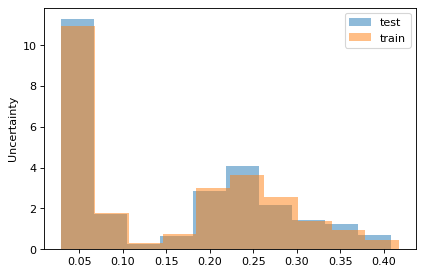

In [49]:
# import numpy as np
# from interpret.visualization_tools import latent_map_2d_gauss, latent_project_gauss, latent_project_cat
import matplotlib.pyplot as plt

if regression_bools[names.index(dname)]:
    
    tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train = \
        latent_project_gauss(BNN, VAE, dset=trainset, batch_size=2048, cuda=cuda)
    
    tr_uncertainty_vec = tr_aleatoric_vec + tr_epistemic_vec

    te_aleatoric_vec, te_epistemic_vec, z_test, x_test, y_test = \
        latent_project_gauss(BNN, VAE, dset=valset, batch_size=2048, cuda=cuda)
    
    te_uncertainty_vec = (te_aleatoric_vec**2 + te_epistemic_vec**2)**(1.0/2)
    
else:
    tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train = \
        latent_project_cat(BNN, vae, dset=trainset, batch_size=2048, cuda=cuda) # x_train,y_train
    
    tr_uncertainty_vec = tr_aleatoric_vec + tr_epistemic_vec
    
    te_aleatoric_vec, te_epistemic_vec, z_test, x_test, y_test = \
        latent_project_cat(BNN, vae, dset=valset, batch_size=2048, cuda=cuda) # x_test,y_test
    
    te_uncertainty_vec = te_aleatoric_vec + te_epistemic_vec

uncertainty_idxs_sorted = np.flipud(np.argsort(te_uncertainty_vec))
aleatoric_idxs_sorted = np.flipud(np.argsort(te_aleatoric_vec))
epistemic_idxs_sorted = np.flipud(np.argsort(te_epistemic_vec))

plt.figure(dpi=80)
plt.hist(te_uncertainty_vec, density=True, alpha=0.5)
plt.hist(tr_uncertainty_vec, density=True, alpha=0.5)
plt.legend(['test', 'train'])
plt.ylabel('Uncertainty')

In [50]:
print(var_names_flat[dname])

['25 - 45', 'Greater than 45', 'Less than 25', 'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other', 'Female', 'Male', 'Felony', 'misdemeanour', 'not_recid', 'is_recid', 'priors_count', 'time_served']


# Overview uncertainty histogram per dataset dimension

Text(0.5, 1.0, 'Felony')

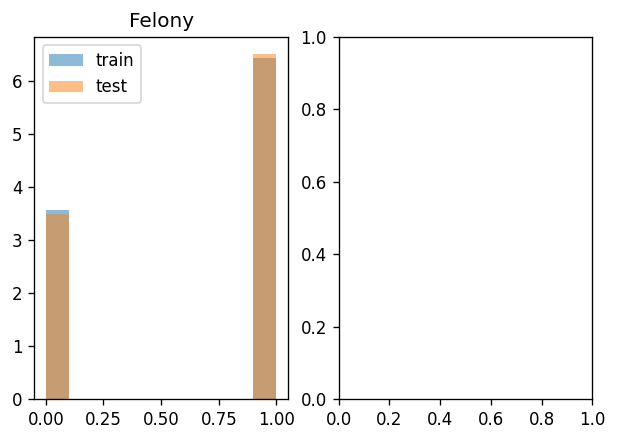

In [60]:
var_N = 11

fig, axes = plt.subplots(1, 2, dpi=120)
# plt.figure(dpi=80)
axes[0].hist(x_train[:,var_N], density=True, alpha=0.5)
axes[0].hist(x_test[:,var_N], density=True, alpha=0.5)
axes[0].legend(['train', 'test'])
axes[0].set_title(var_names_flat[dname][var_N])

In [84]:
bins = [-5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5]
center_bins = ((np.array([0] + bins) + np.array(bins + [0]))/2)[1:]
center_bins[-1] = bins[-1]

bin_idx = np.digitize(x_train[:, var_N], bins, right=False)
bin_means = []
bin_stds = []
aleatoric_mean = []
aleatoric_stds = []
epistemic_mean = []
epistemic_stds = []

for n_bin, bin_start in enumerate(bins):
    y_select = y_train[bin_idx==n_bin]
    aleatoric_select = tr_aleatoric_vec[bin_idx==n_bin]
    epistemic_select = tr_epistemic_vec[bin_idx==n_bin]
    if len(y_select) == 0:
        bin_means.append(np.nan)
        bin_stds.append(np.nan)
        aleatoric_mean.append(np.nan)
        aleatoric_stds.append(np.nan)
        epistemic_mean.append(np.nan)
        epistemic_stds.append(np.nan)
    else:
        bin_means.append(y_select.mean())
        bin_stds.append(y_select.std())
        aleatoric_mean.append(aleatoric_select.mean())
        aleatoric_stds.append(aleatoric_select.std())
        epistemic_mean.append(epistemic_select.mean())
        epistemic_stds.append(epistemic_select.std())

<Figure size 432x288 with 0 Axes>

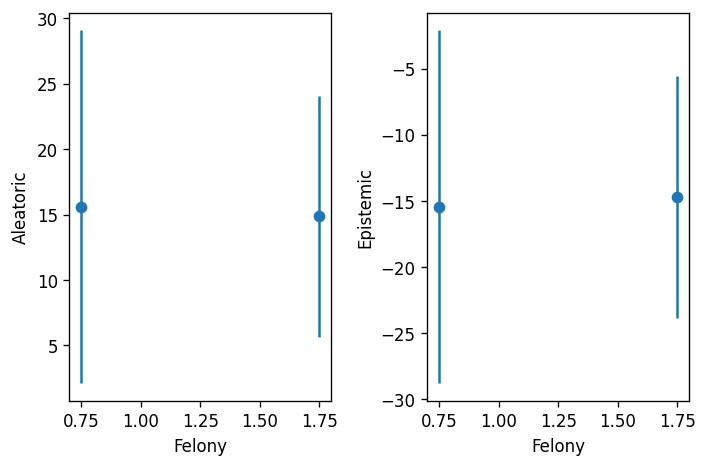

In [87]:
axes[1].errorbar(center_bins, bin_means, yerr=bin_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('target var')

plt.tight_layout()

fig, axes = plt.subplots(1, 2, dpi=120)
axes[0].errorbar(center_bins, aleatoric_mean, yerr=aleatoric_stds, fmt='o')
axes[0].set_xlabel(var_names_flat[dname][var_N])
axes[0].set_ylabel('Aleatoric')

axes[1].errorbar(center_bins, epistemic_mean, yerr=epistemic_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('Epistemic')

plt.tight_layout()
# plt.show()

In [53]:
tr_aleatoric_vec

array([ 3.7001734, 28.728306 ,  5.2988954, ...,  5.042375 ,  8.642808 ,
        3.2509427], dtype=float32)